<a href="https://colab.research.google.com/github/foxtrotmike/ALBRT/blob/main/SAIL_maths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 📐 Spatial Autocorrelation Index Layer (SAIL) — Multi-Head Formulation

(Fayyaz Minhas)

The Spatial Autocorrelation Index Layer (SAIL) is a neural module designed to **quantify and learn spatial dependencies in graph-structured data**, inspired by [**Moran’s I**](https://en.wikipedia.org/wiki/Moran%27s_I) — a classical measure of spatial autocorrelation.

In spatial statistics, Moran's I captures how similar a variable (e.g., gene expression, cell phenotype etc.) is across neighboring spatial locations. This layer extends that idea into a **learnable, attention-based neural framework** that operates on graphs where nodes have both **features** and **spatial coordinates**.

In the context of **tissue heterogeneity analysis**, such as spatial transcriptomics or cellular histology, SAIL can help identify spatially coherent patterns of gene expression, morphology, or signaling — enabling downstream tasks like **tumor subtyping**, **niche discovery**, or **spatial phenotype classification**.

Unlike classical Moran’s I, SAIL:
- Learns **which features** to correlate,
- Learns how spatial proximity should **modulate interaction strength**,
- Allows masking by actual **graph connectivity** (e.g., tissue segmentation, Delaunay triangulation),
- And generalizes to multiple attention heads to capture **diverse spatial modes**.

The layer computes a **multi-head graph-level representation** $f(G)$ reflecting the spatial organization of node features, which can be used for classification, regression, or further downstream learning.


Given a graph $G = (V, E)$ with:
- Node features $\mathbf{x}_i \in \mathbb{R}^d$
- Node coordinates $\mathbf{p}_i \in \mathbb{R}^c$
- Optional edge list $E \subseteq V \times V$

Let $n = |V|$ be the number of nodes.

---

### 🧮 Step 1: Pairwise Distance Matrix

Compute squared pairwise distances:

$$
D_{ij}^2 = \|\mathbf{p}_i - \mathbf{p}_j\|^2
$$

Optionally normalized by:
- A fixed constant $\mu_D$, or
- The median pairwise distance.

---

### 🔁 Step 2: Multi-Head Spatial Autocorrelation (for $h = 1, \dots, H$ heads)

Each head has:
- A feature mapping $f_{\text{map}}^{(h)} : \mathbb{R}^d \to \mathbb{R}$
- A **spatial spread function** $f_\theta^{(h)} : \mathbb{R}^d \times \mathbb{R}^d \to \mathbb{R}_+$
- A temperature parameter $T^{(h)} > 0$ (learnable or fixed)

---

#### 2.1 Scalar Feature Mapping

For each node:

$$
z_i^{(h)} = f_{\text{map}}^{(h)}(\mathbf{x}_i)
$$

Center the features:

$$
\tilde{z}_i^{(h)} = z_i^{(h)} - \mu_z^{(h)}, \quad \text{where } \mu_z^{(h)} = \frac{1}{n} \sum_{i=1}^n z_i^{(h)}
$$

Variance:

$$
\sigma_z^{2(h)} = \frac{1}{n} \sum_{i=1}^n (\tilde{z}_i^{(h)})^2 + \varepsilon
$$

---

#### 2.2 Spatial Spread Coefficient

For each node pair:

$$
\theta_{ij}^{(h)} = f_\theta^{(h)}(\mathbf{x}_i, \mathbf{x}_j)
$$

This controls **how sharply distance penalizes** the interaction between node $i$ and $j$. Larger $\theta_{ij}$ implies faster spatial decay.

---

#### 2.3 Attention Logits and Masking

Compute logits:

$$
\ell_{ij}^{(h)} = -\frac{\theta_{ij}^{(h)} \cdot D_{ij}^2}{T^{(h)} + \varepsilon}
$$

If edge masking is **enabled**, define the mask:

$$
M_{ij} =
\begin{cases}
0 & \text{if } (i, j) \in E \\
-\infty & \text{otherwise}
\end{cases}
$$

Apply the mask before softmax:

$$
\tilde{\ell}_{ij}^{(h)} = \ell_{ij}^{(h)} + M_{ij}
$$

Compute attention weights:

$$
\alpha_{ij}^{(h)} = \frac{\exp(\tilde{\ell}_{ij}^{(h)})}{\sum_{k=1}^n \exp(\tilde{\ell}_{ik}^{(h)})}
$$

If edge masking is **not enabled**, then:

$$
\alpha_{ij}^{(h)} = \text{softmax}_j(\ell_{ij}^{(h)})
$$

---

#### 2.4 Local Spatial Autocorrelation Score

Each node’s local index:

$$
I_i^{(h)} = \frac{\tilde{z}_i^{(h)}}{\sigma_z^{2(h)}} \sum_{j=1}^n \alpha_{ij}^{(h)} \tilde{z}_j^{(h)}
$$

---

#### 2.5 Global Moran-like Index (per head)

Average over all nodes:

$$
I_{\text{global}}^{(h)} = \frac{1}{n} \sum_{i=1}^n I_i^{(h)}
$$

---

### 🧠 Final Output for the Graph $G$

The **graph-level embedding** from the spatial autocorrelation layer is:

$$
f(G) = \left[I_{\text{global}}^{(1)}, I_{\text{global}}^{(2)}, \dots, I_{\text{global}}^{(H)}\right] \in \mathbb{R}^H
$$

This can be passed to a classifier or regressor (e.g., MLP).

---

### 📤 Optional Outputs
- Local scores $I_i^{(h)}$
- Attention weights $\alpha_{ij}^{(h)}$
- Spread control values $\theta_{ij}^{(h)}$

---

### ✅ Summary
This formulation generalizes Moran’s I by:
- Learning how feature similarity and spatial proximity interact.
- Allowing flexible attention over node pairs.
- Supporting edge-aware computation for structured graphs.


In [ ]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

class SpatialAutocorrelationIndexLayer(nn.Module):
    """
    Computes a multi-head spatial autocorrelation index for graph data,
    where each head models spatial relationships using a learned kernel function.

    Args:
        f_map (nn.Module or nn.ModuleList):
            Module(s) that map input node features to scalar values for autocorrelation.
            If a single module is provided, it is cloned per head.

        f_theta (nn.Module or nn.ModuleList):
            Module(s) that compute pairwise affinity between node features.
            Must return an (n, n) matrix when called with (x, x).

        num_heads (int):
            Number of attention heads to use. Defaults to 1.

        mu_D (float):
            Normalization factor for distances if `use_median_distance` is False. Defaults to 1.0.

        eps (float):
            Small value to prevent division by zero. Defaults to 1e-6.

        temperature (float):
            Initial value for the temperature used in attention scaling. Defaults to 1.0.

        learnable_temperature (bool):
            If True, temperature is a learnable parameter for each head. Defaults to False.

        use_median_distance (bool):
            If True, normalizes distances by the median pairwise distance instead of `mu_D`. Defaults to False.

        use_edge_connections (bool):
            If True, restricts attention weights to existing edges in `graph.edge_index`. Defaults to False.

        reinit_weights (bool):
            If True, reinitializes cloned modules with their `reset_parameters()` method. Defaults to True.

        dfun (function):
            Function to compute pairwise distances. Defaults to torch.cdist.
    """
    def __init__(
        self,
        f_map,
        f_theta,
        num_heads: int = 1,
        mu_D: float = 1.0,
        eps: float = 1e-6,
        temperature: float = 1.0,
        learnable_temperature: bool = False,
        use_median_distance: bool = False,
        use_edge_connections: bool = False,
        reinit_weights: bool = True,
        dfun = torch.cdist
    ):
        super().__init__()
        self.num_heads = num_heads
        self.eps = eps
        self.mu_D = mu_D
        self.use_median_distance = use_median_distance
        self.use_edge_connections = use_edge_connections
        self.dfun = dfun

        # Clone f_map per head
        if isinstance(f_map, nn.ModuleList):
            assert len(f_map) == num_heads
            self.f_maps = f_map
        elif isinstance(f_map, nn.Module):
            self.f_maps = self._maybe_clone_and_reinit(f_map, num_heads, reinit_weights)
        else:
            raise TypeError("f_map must be nn.Module or nn.ModuleList")

        # Clone f_theta per head
        if isinstance(f_theta, nn.ModuleList):
            assert len(f_theta) == num_heads
            self.f_thetas = f_theta
        elif isinstance(f_theta, nn.Module):
            self.f_thetas = self._maybe_clone_and_reinit(f_theta, num_heads, reinit_weights)
        else:
            raise TypeError("f_theta must be nn.Module or nn.ModuleList")

        # Temperature per head
        temp_tensor = torch.tensor(temperature)
        if learnable_temperature:
            self.temperatures = nn.ParameterList([
                nn.Parameter(temp_tensor.clone()) for _ in range(num_heads)
            ])
        else:
            self.register_buffer("temperatures", torch.stack([temp_tensor.clone()] * num_heads))

    def forward(self, graph, return_attention: bool = False):
        """
        Computes the spatial autocorrelation index over a graph.

        Args:
            graph (object):
                A graph object containing:
                    - `x`: Node features of shape (n, d)
                    - `coords`: Node coordinates of shape (n, c)
                    - Optional `edge_index`: Edge list in COO format (2, E)
                    - Optional `_cached_dists`: Cached distance matrix (n, n)

            return_attention (bool):
                If True, also return (theta_ij, a_ij) for each head.

        Returns:
            global_I (torch.Tensor): (H,)
                Mean autocorrelation index across all nodes for each head.
            local_I_all (torch.Tensor): (n, H)
                Per-node autocorrelation indices for each head.

            Optionally (if return_attention=True):
                theta_list (List[Tensor]): List of (n, n) θ_ij matrices, one per head.
                attn_list (List[Tensor]): List of (n, n) a_ij matrices, one per head.
        """
        x = graph.x
        coords = graph.coords
        n = x.shape[0]

        # Precompute distances (or use cache)
        if hasattr(graph, "_cached_dists") and graph._cached_dists is not None:
            dists_sq = graph._cached_dists
        else:
            dists = self.dfun(coords, coords)
            if self.use_median_distance:
                median_d = torch.median(dists.detach())
                dists = dists / (median_d + self.eps)
            else:
                dists = dists / self.mu_D
            dists_sq = dists #** 2
            graph._cached_dists = dists_sq.detach()

        # Optional: use edge_index to mask neighbors
        if self.use_edge_connections and hasattr(graph, "edge_index"):
            edge_mask = torch.full((n, n), float("-inf"), device=x.device)
            i, j = graph.edge_index
            edge_mask[i, j] = 0.0
        else:
            edge_mask = None

        local_I_all = []
        theta_list = []
        attn_list = []

        for h in range(self.num_heads):
            z = self.f_maps[h](x).squeeze(-1)  # (n,)
            mu_z = z.mean()
            var_z = z.var(unbiased=False) + self.eps
            z_centered = z - mu_z

            theta_ij = self.f_thetas[h](x, x)  # (n, n)
            T = self.temperatures[h] if isinstance(self.temperatures, nn.ParameterList) else self.temperatures[h]

            logits = -theta_ij * dists_sq / (T + self.eps)

            if edge_mask is not None:
                logits = logits + edge_mask

            a_ij = F.softmax(logits, dim=1)  # (n, n)
            # Flatten, apply global softmax, and reshape
            # a_ij = F.softmax(logits.view(-1), dim=0).view_as(logits)

            # Optional sanity check (numerical precision)
            # assert torch.allclose(a_ij.sum(), torch.tensor(1.0, device=a_ij.device), atol=1e-5)

            weighted_sum = torch.matmul(a_ij, z_centered)
            local_I = (z_centered / var_z) * weighted_sum
            local_I_all.append(local_I)

            if return_attention:
                theta_list.append(theta_ij.detach())
                attn_list.append(a_ij.detach())

        local_I_all = torch.stack(local_I_all, dim=1)  # (n, H)

        global_I = local_I_all.mean(dim=0)  # (H,)

        if return_attention:
            return global_I, local_I_all, theta_list, attn_list
        else:
            return global_I, local_I_all


    def _maybe_clone_and_reinit(self, module: nn.Module, num_clones: int, reinit: bool):
        """
        Clones a module multiple times, with optional reinitialization.

        Args:
            module (nn.Module):
                The base module to clone.

            num_clones (int):
                Number of times to clone the module.

            reinit (bool):
                Whether to call `reset_parameters()` on each clone.

        Returns:
            nn.ModuleList:
                List of cloned and optionally reinitialized modules.
        """
        clones = []
        for _ in range(num_clones):
            clone = copy.deepcopy(module)
            if reinit:
                self._reinitialize_module_weights(clone)
            clones.append(clone)
        return nn.ModuleList(clones)

    def _reinitialize_module_weights(self, module: nn.Module):
        """
        Recursively reinitializes all submodules that implement `reset_parameters()`.

        Args:
            module (nn.Module):
                The module whose weights will be reset.
        """
        for m in module.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()





In [ ]:

class SingleFeature(nn.Module):
    """
    A simple mapping function that extracts a single feature dimension (e.g., the 0-th) from node features.
    Useful for computing Moran's I on scalar features.
    """
    def __init__(self, feature_index=0):
        super().__init__()
        self.feature_index = feature_index

    def forward(self, x):
        return x[:, self.feature_index]


class FixedTheta(nn.Module):
    """
    A simple affinity function that returns a constant value θ for all node pairs.
    Simulates uniform spatial influence across all pairs.
    """
    def __init__(self, theta: float):
        super().__init__()
        self.theta = theta

    def forward(self, x_i, x_j):
        n = x_i.size(0)
        return torch.full((n, n), self.theta, device=x_i.device)

class DummyGraph:
    """
    Minimal graph data structure that stores:
        - Node features `x`
        - Node coordinates `coords`
        - (Optional) `edge_index` for edge-based masking
        - (Optional) `_cached_dists` for distance reuse
    """
    def __init__(self, x, coords):
        self.x = x
        self.coords = coords
        self._cached_dists = None


# --- Graph Generators ---

def generate_random_graph(n=100, d=5):
    """
    Generates a graph with random features and 2D coordinates.
    Should exhibit near-zero Moran's I.
    """
    return DummyGraph(torch.rand(n, d), torch.rand(n, 2))

def generate_high_moran_graph(grid_size=20, noise=0.00):
    """
    Generates a grid-based graph with rook (4-neighbor) connectivity.
    Features vary smoothly across the grid: x = x_coord + y_coord (+ noise),
    producing high spatial autocorrelation (Moran's I ≈ +1).
    """
    # Generate grid coordinates
    x_coords = torch.linspace(0, 1, grid_size)
    y_coords = torch.linspace(0, 1, grid_size)
    xv, yv = torch.meshgrid(x_coords, y_coords)#, indexing='ij')  # Use 'ij' for row-major order
    coords = torch.stack([xv.flatten(), yv.flatten()], dim=1)  # (N, 2)

    # Generate features: smooth function of position + noise
    features = (coords[:, 0] + coords[:, 1]).unsqueeze(1)
    features += noise * torch.randn_like(features)

    # Create edge_index using rook (4-neighbor) connectivity
    def node_index(i, j):
        return i * grid_size + j

    edges = []
    for i in range(grid_size):
        for j in range(grid_size):
            current = node_index(i, j)
            for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # rook neighbors
                ni, nj = i + di, j + dj
                if 0 <= ni < grid_size and 0 <= nj < grid_size:
                    neighbor = node_index(ni, nj)
                    edges.append((current, neighbor))

    # Make edges undirected by adding reverse
    edge_index = torch.tensor(edges + [(j, i) for i, j in edges], dtype=torch.long).t().contiguous()

    # Return DummyGraph object
    graph = DummyGraph(x=features, coords=coords)
    graph.edge_index = edge_index
    return graph


def generate_checker_moran_graph(grid_size=10):
    """
    Generates a checkerboard pattern of alternating +1/-1 values.
    Uses 4-neighbor (rook) connectivity to define spatial neighbors.
    Should yield a strongly negative Moran's I.
    """
    # Grid coordinates in [0, 1] x [0, 1]
    coords = torch.stack(torch.meshgrid(
        torch.linspace(0, 1, grid_size),
        torch.linspace(0, 1, grid_size),
        #indexing='ij'
    ), dim=-1).reshape(-1, 2)

    # Checkerboard feature: alternating 0 and 1 values
    indices = torch.arange(grid_size)
    xx, yy = torch.meshgrid(indices, indices)#, indexing='ij')
    checker = ((xx + yy) % 2).float().flatten().unsqueeze(1)
    checker -= checker.mean()  # zero-mean centering

    # Construct graph
    graph = DummyGraph(x=checker, coords=coords)

    # Create rook connectivity edges (4-neighbors)
    def idx(i, j): return i * grid_size + j
    edges = []
    for i in range(grid_size):
        for j in range(grid_size):
            curr = idx(i, j)
            for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
                if 0 <= ni < grid_size and 0 <= nj < grid_size:
                    neigh = idx(ni, nj)
                    edges.append((curr, neigh))
                    edges.append((neigh, curr))  # undirected

    # Register edges
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    graph.edge_index = edge_index

    return graph


# --- Visualization Function ---

def visualize_graph(
    graph: DummyGraph,
    moran_I: torch.Tensor,
    title: str = "Graph Visualization",
    feature_index: int = 0,
    show: str = "local"
):
    """
    Visualizes a graph with NetworkX.

    Args:
        graph (DummyGraph): The graph object containing node coordinates and features.
        moran_I (torch.Tensor): Either a (n,) tensor of local Moran's I values or a scalar (global).
        title (str): Title of the plot.
        feature_index (int): Which feature index in `graph.x` to color nodes with. Defaults to 0.
        show (str): One of {"local", "global"} — whether to display local Moran's I (per-node)
                    or a single global value.
    """
    coords = graph.coords.detach().cpu().numpy()
    features = graph.x[:, feature_index].detach().cpu().numpy()

    if show == "local":
        local_I_np = moran_I.squeeze().detach().cpu().numpy()
        assert local_I_np.shape[0] == coords.shape[0], "Local Moran's I must match number of nodes"
    elif show == "global":
        global_I_value = moran_I.item()
    else:
        raise ValueError("`show` must be either 'local' or 'global'")

    G = nx.Graph()
    n = coords.shape[0]

    # Add nodes with 2D positions
    for i in range(n):
        G.add_node(i, pos=(coords[i][0], coords[i][1]))

    # Add edges if available
    if hasattr(graph, "edge_index") and graph.edge_index is not None:
        edge_index = graph.edge_index.detach().cpu().numpy()
        for i, j in zip(edge_index[0], edge_index[1]):
            G.add_edge(int(i), int(j))

    pos = nx.get_node_attributes(G, 'pos')

    # Plot base graph
    plt.figure(figsize=(7, 7))
    nx.draw(
        G,
        pos,
        node_color=features,
        cmap='coolwarm',
        node_size=80,
        edge_color='lightgray',
        linewidths=0.5,
        with_labels=False
    )

    # Add node labels
    if show == "local":
        labels = {i: f"{local_I_np[i]:.2f}" for i in range(n)}
        nx.draw_networkx_labels(G, pos, labels, font_size=6, font_color='black')
    elif show == "global":
        plt.text(
            0.5, 1.01,
            f"Global Moran's I: {global_I_value:.4f}",
            ha='center',
            va='bottom',
            transform=plt.gca().transAxes,
            fontsize=12,
            fontweight='bold'
        )

    plt.title(title)
    plt.axis('equal')
    plt.show()





### 🧪 Validation of SAIL using Known Graph Structures

This experiment validates the behavior of **SAIL** by computing **Moran's I** on synthetic graphs with known spatial patterns:

- **Random Graph**: Features and coordinates are sampled independently.  
  → **Expected Moran’s I ≈ 0** (no spatial correlation)

- **Smooth Gradient Graph**: Features vary smoothly over a 2D grid.  
  → **Expected Moran’s I ≈ +1** (strong positive correlation)

- **Checkerboard Graph**: Alternating +1/–1 pattern on a grid.  
  → **Expected Moran’s I < 0** (strong negative correlation)

We use:
- `f_map`: Extracts a single scalar feature
- `f_theta`: Fixed θ = 3.0 (uniform spatial spread)
- `use_edge_connections=True`: Attention is restricted to 4-neighbor grid connections

These tests confirm that SAIL reproduces classical spatial autocorrelation behavior across positive, neutral, and negative spatial patterns.


[Random Graph]     Moran's I ≈ 0:    0.0756


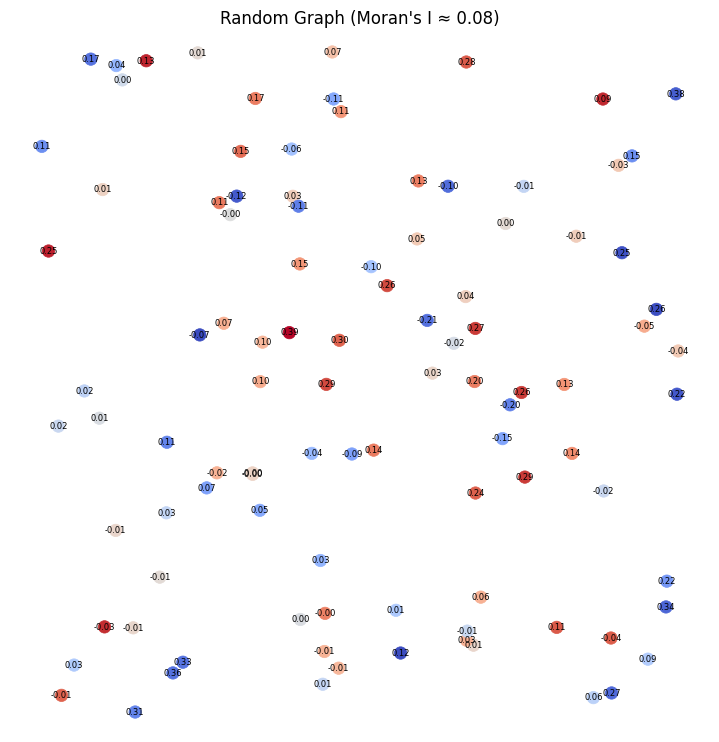

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[High Correlation] Moran's I ≈ +1:   0.9900


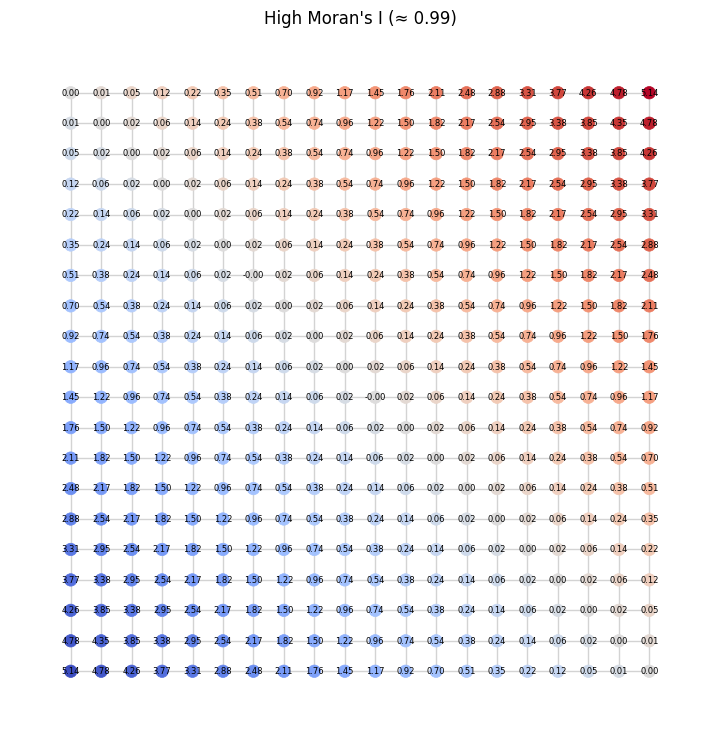

[Checkerboard]     Moran's I ≈ -1:   -1.0000


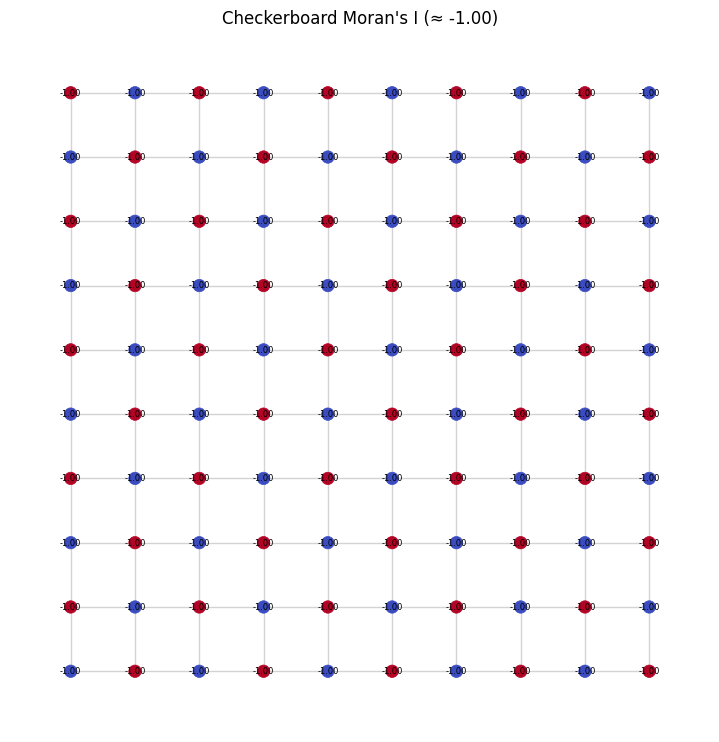

In [ ]:


# --- Testing and Visualization ---

# Define feature and kernel
f_map = SingleFeature(feature_index=0)
f_theta = FixedTheta(theta=3.0)

# Instantiate Moran's I layer
layer = SpatialAutocorrelationIndexLayer(
    f_map=f_map,
    f_theta=f_theta,
    num_heads=1,
    use_median_distance=True,
    reinit_weights=False,
    use_edge_connections=True
)

# Test 1: Random Graph (Expected Moran's I ≈ 0)
rand_graph = generate_random_graph()
global_I_rand, local_I_rand = layer(rand_graph)
print(f"[Random Graph]     Moran's I ≈ 0:    {global_I_rand.item():.4f}")
visualize_graph(rand_graph, local_I_rand, title=f"Random Graph (Moran's I ≈ {global_I_rand.item():.2f})")

# Test 2: Smooth Gradient (Expected Moran's I ≈ +1)
hi_graph = generate_high_moran_graph()
global_I_high, local_I_high = layer(hi_graph)
print(f"[High Correlation] Moran's I ≈ +1:   {global_I_high.item():.4f}")
visualize_graph(hi_graph, local_I_high, title=f"High Moran's I (≈ {global_I_high.item():.2f})")

# Test 3: Checkerboard (Expected Moran's I < 0)
neg_graph = generate_checker_moran_graph()
global_I_neg, local_I_neg, T, A = layer.forward(neg_graph,return_attention = True)
print(f"[Checkerboard]     Moran's I ≈ -1:   {global_I_neg.item():.4f}")
visualize_graph(neg_graph, local_I_neg, title=f"Checkerboard Moran's I (≈ {global_I_neg.item():.2f})")

In [ ]:
def compute_global_morans_I_for_all_features(graph, theta=3.0, use_median_distance=True, use_edge_connections=True):
    """
    Computes the global Moran's I for each feature dimension independently
    using a fixed theta kernel.

    Args:
        graph (DummyGraph): Graph with `x` and `coords` attributes.
        theta (float): Fixed θ value for affinity function.
        use_median_distance (bool): Whether to normalize distances by the median.
        use_edge_connections (bool): Whether to mask affinities by existing edges.

    Returns:
        global_Is (torch.Tensor): Shape (d,) where d = number of feature dimensions.
            Each entry is the global Moran's I for that feature.
    """
    d = graph.x.shape[1]  # Number of features
    global_Is = []

    for feature_idx in range(d):
        f_map = SingleFeature(feature_index=feature_idx)
        f_theta = FixedTheta(theta=theta)

        layer = SpatialAutocorrelationIndexLayer(
            f_map=f_map,
            f_theta=f_theta,
            num_heads=1,
            use_median_distance=use_median_distance,
            use_edge_connections=use_edge_connections,
            reinit_weights=False
        )

        global_I, _ = layer(graph)
        global_Is.append(global_I.item())  # Convert scalar tensor to float

    return torch.tensor(global_Is)

rand_graph = generate_random_graph(n=100, d=5)
global_Is = compute_global_morans_I_for_all_features(rand_graph, theta=3.0)
print("Global Moran's I per feature:", global_Is)


Global Moran's I per feature: tensor([0.0819, 0.0717, 0.0507, 0.0765, 0.0858])


### 🧪 Experiment: Learning Spatial Heterogeneity with SAIL

This experiment tests the ability of the **Spatial Autocorrelation Index Layer (SAIL)** to distinguish graphs based on the **spatial structure of node features**.

We simulate two classes of graphs:
- **Positive class (label = 1)**: Node features vary smoothly with spatial coordinates.
- **Negative class (label = 0)**: Node coordinates are randomly shuffled, breaking spatial structure.

Each graph has 20–50 nodes, 2D coordinates, and 3D node features (linear projection of coords + noise).

We train a classifier using:
- `f_map`: Linear projection to scalar features
- `f_theta`: Fixed or learned spatial spread (θ)
- MLP on global Moran's I scores for graph-level classification

The model learns to detect spatial autocorrelation patterns and generalizes to unseen graphs. We visualize **local Moran's I** maps to interpret spatial sensitivity.



Epoch 01 | Train Acc: 0.000 | Val Acc: 0.380
Epoch 02 | Train Acc: 0.857 | Val Acc: 0.960
Epoch 03 | Train Acc: 0.908 | Val Acc: 0.980
Epoch 04 | Train Acc: 0.917 | Val Acc: 0.980
Epoch 05 | Train Acc: 0.920 | Val Acc: 0.980
Epoch 06 | Train Acc: 0.920 | Val Acc: 0.980
Epoch 07 | Train Acc: 0.925 | Val Acc: 0.980
Epoch 08 | Train Acc: 0.927 | Val Acc: 0.980
Epoch 09 | Train Acc: 0.928 | Val Acc: 0.980
Epoch 10 | Train Acc: 0.930 | Val Acc: 0.980
Epoch 11 | Train Acc: 0.933 | Val Acc: 0.980
Epoch 12 | Train Acc: 0.935 | Val Acc: 0.980
Epoch 13 | Train Acc: 0.935 | Val Acc: 0.980
Epoch 14 | Train Acc: 0.935 | Val Acc: 0.980
Epoch 15 | Train Acc: 0.935 | Val Acc: 0.980
Epoch 16 | Train Acc: 0.935 | Val Acc: 0.980
Epoch 17 | Train Acc: 0.935 | Val Acc: 0.980
Epoch 18 | Train Acc: 0.935 | Val Acc: 0.980
Epoch 19 | Train Acc: 0.935 | Val Acc: 0.980
Epoch 20 | Train Acc: 0.937 | Val Acc: 0.980


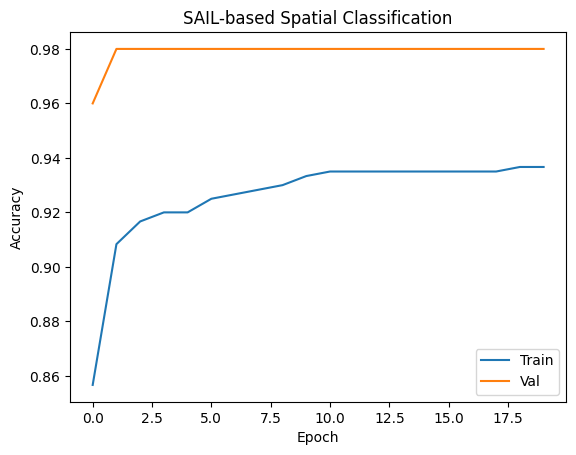


Visualizing learned Moran's I on validation graphs...



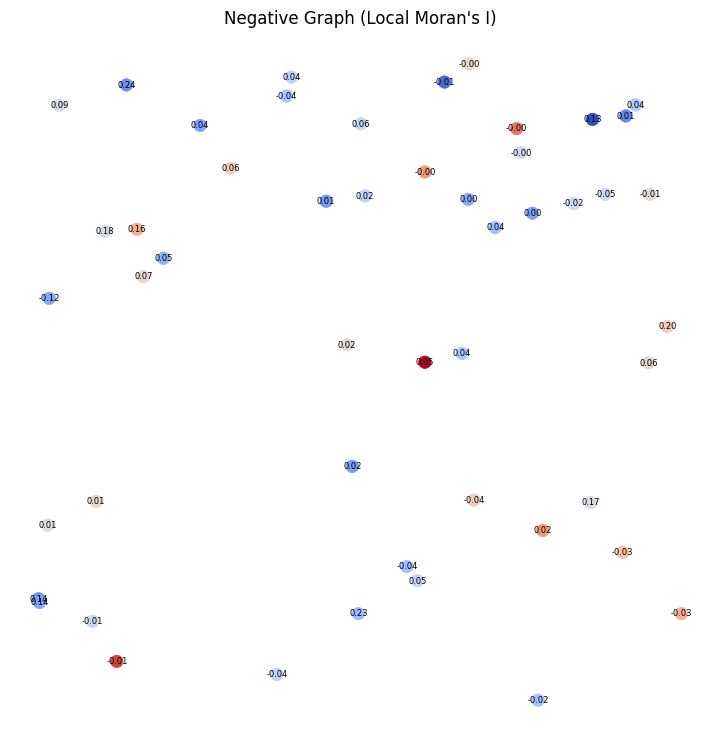

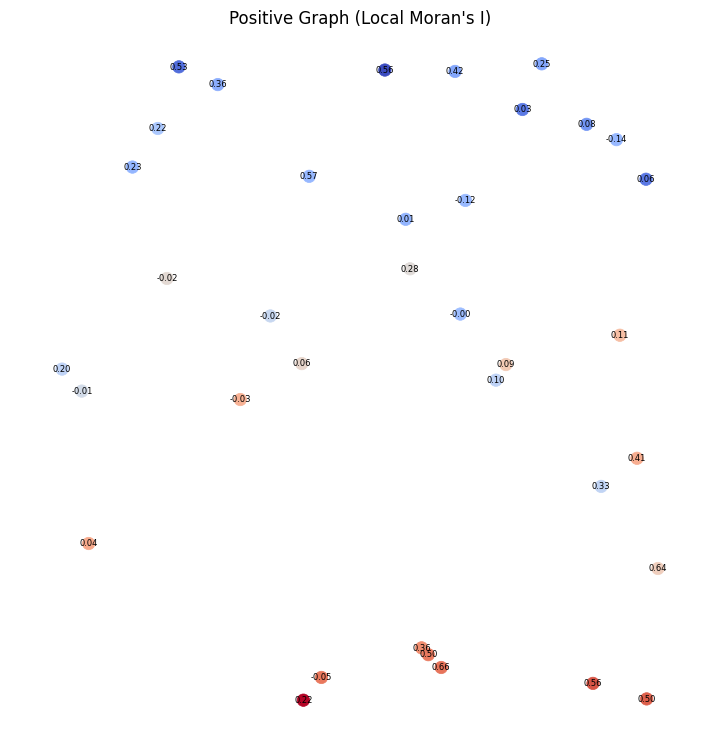

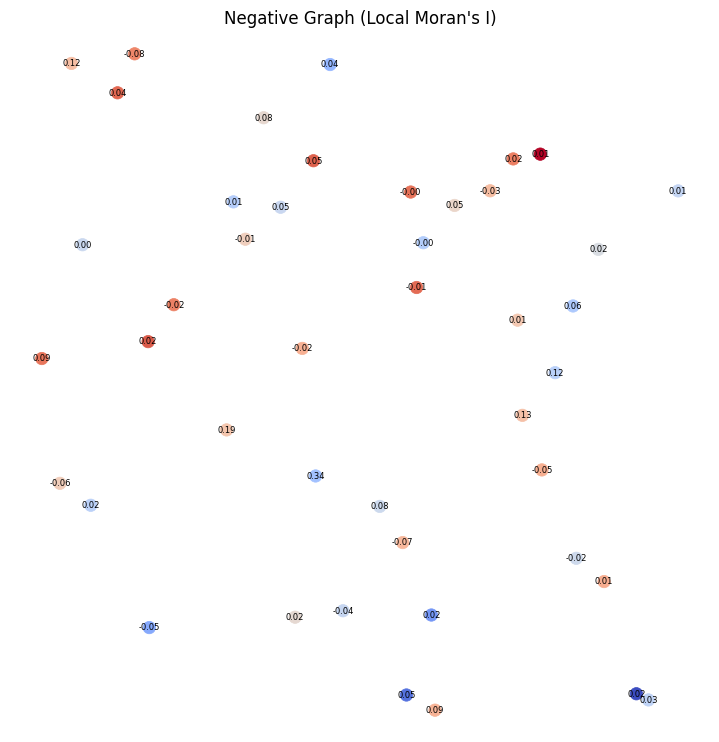

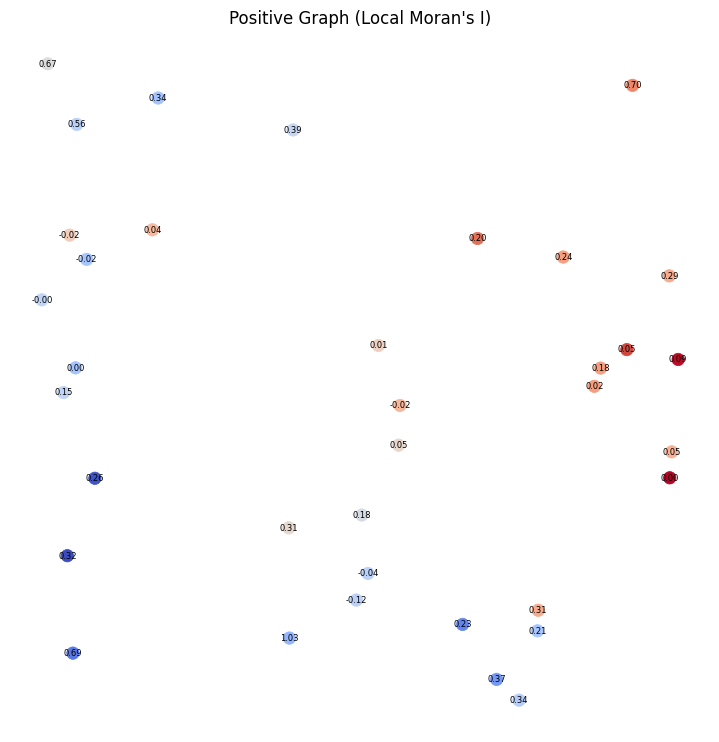

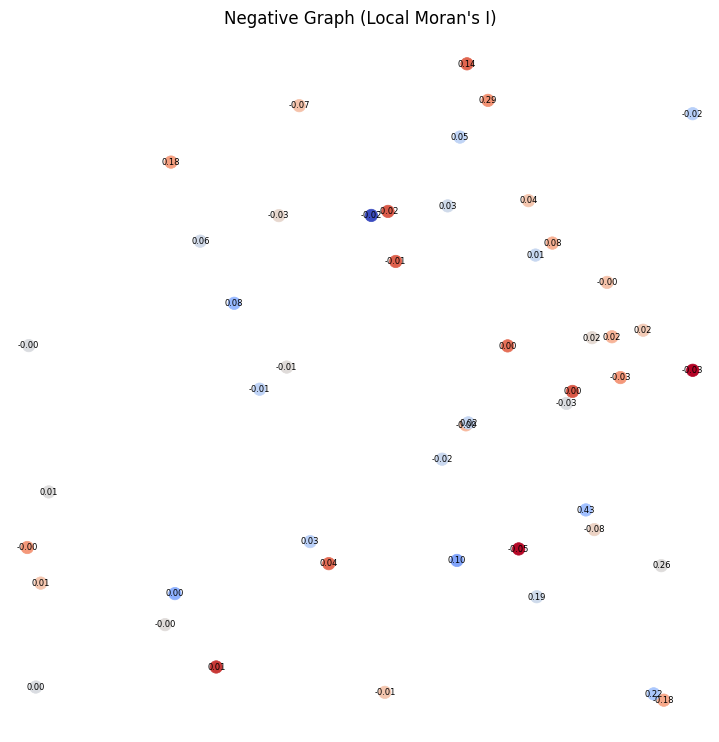

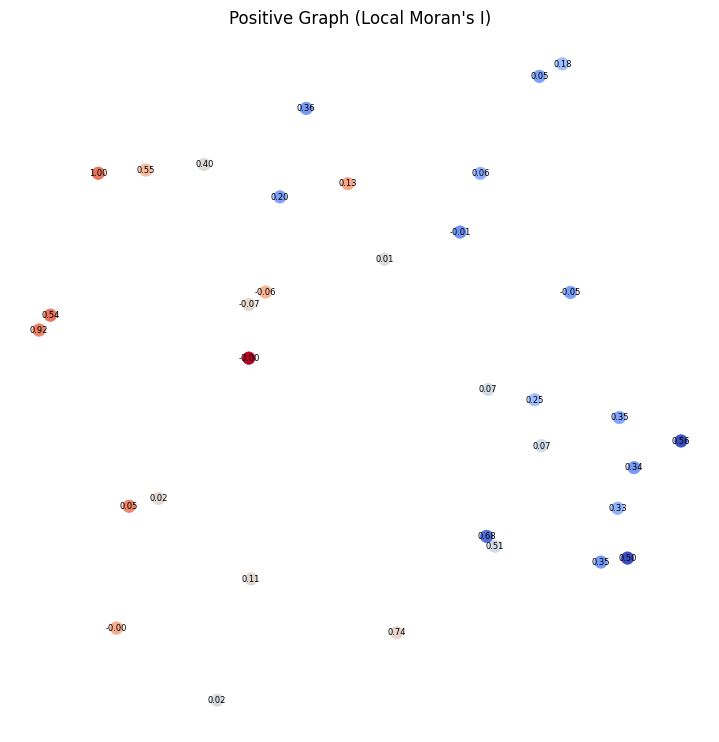

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
# --- Learnable theta module takes start theta to produce theta---
class LearnableSingleTheta(nn.Module):
    def __init__(self, init=10.0):
        super().__init__()
        self.theta = nn.Parameter(torch.tensor(float(init)))

    def forward(self, x_i, x_j):
        return self.theta.expand(x_i.size(0), x_j.size(0))

# --- Learnable theta module takes 2 node features to produce theta---
class LearnableTheta(nn.Module):
    def __init__(self, in_dim):
        """
        Args:
            input_dim (int): Dimensionality of input node features (i.e., x_i.shape[1])
        """
        super().__init__()
        # Since we concatenate x_i and x_j, the input to the layer will be 2 * input_dim
        self.linear = nn.Linear(2 * in_dim, 1)

    def forward(self, x_i, x_j):
        n = x_i.size(0)
        # Expand x_i and x_j into (n, n, d) for pairwise concatenation
        x_i_exp = x_i.unsqueeze(1).expand(n, n, -1)  # (n, n, d)
        x_j_exp = x_j.unsqueeze(0).expand(n, n, -1)  # (n, n, d)

        # Concatenate along feature dimension
        x_cat = torch.cat([x_i_exp, x_j_exp], dim=-1)  # (n, n, 2d)

        # Apply linear layer
        theta_ij = self.linear(x_cat).squeeze(-1)  # (n, n)
        return theta_ij

class FeatureAverager(nn.Module):
    """
    A simple mapping function that averages all feature dimensions for each node.
    Useful for reducing node features to a scalar per node, e.g., for scalar spatial statistics.
    """
    def __init__(self):
        super().__init__()

    def forward(self, x):
        """
        Args:
            x (Tensor): Node feature matrix of shape (num_nodes, num_features)

        Returns:
            Tensor: A tensor of shape (num_nodes,) with the average feature value per node.
        """
        return x.mean(dim=1)

# --- Simple projection to scalar for f_map ---
class LinearFeatureMap(nn.Module):
    def __init__(self, in_dim=3):
        super().__init__()
        self.linear = nn.Linear(in_dim, 1)

    def forward(self, x):
        return self.linear(x)


# --- Dummy graph container ---
class DummyGraph:
    def __init__(self, x, coords, label):
        self.x = x
        self.coords = coords
        self.label = label
        self._cached_dists = None
        self.edge_index = None


# --- Dataset: variable nodes, noise, randomization ---
class RealisticGraphDataset(Dataset):
    def __init__(self, num_graphs=100, min_nodes=20, max_nodes=50, noise=0.3):
        self.graphs = []
        self.min_nodes = min_nodes
        self.max_nodes = max_nodes
        self.noise = noise
        for _ in range(num_graphs):
            label = random.choice([0, 1])
            self.graphs.append(self._make_graph(label))

    def _make_graph(self, label):
        n = random.randint(self.min_nodes, self.max_nodes)

        # Generate coordinates
        coords = 2*torch.rand(n, 2)-1

        # Feature = coord @ linear matrix + noise
        weights = 2*torch.rand(2, 3)-1
        base_features = coords @ weights
        base_features += self.noise * torch.randn_like(base_features)

        if label == 0:
            # Negative class: break spatial alignment by shuffling coords
            coords = coords[torch.randperm(n)]

        return DummyGraph(x=base_features, coords=coords, label=label)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]


# --- Classifier using SAIL ---
class MoranClassifier(nn.Module):
    def __init__(self, sail: nn.Module, input_dim: int):
        super().__init__()
        self.sail = sail
        self.mlp = nn.Sequential(
            #nn.Linear(input_dim, 4),
            #nn.ReLU(),
            nn.Linear(input_dim, 2)
        )

    def forward(self, graph):
        _, local_I = self.sail(graph)             # local_I: shape (n_nodes, num_heads)
        local_I_tanh = torch.tanh(local_I)        # apply tanh nonlinearity
        pooled = local_I_tanh.mean(dim=0)         # average over nodes → shape: (num_heads,)
        return self.mlp(pooled)                   # pass through MLP



# --- Train and eval loops ---
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0
    for graph in dataloader:
        optimizer.zero_grad()
        out = model(graph)
        label = torch.tensor([graph.label], dtype=torch.long, device=out.device)
        loss = criterion(out.unsqueeze(0), label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (out.argmax() == label).item()
    return total_loss / len(dataloader), correct / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for graph in dataloader:
            out = model(graph)
            label = torch.tensor(graph.label, device=out.device)
            correct += (out.argmax() == label).item()
    return correct / len(dataloader)


# --- Experiment wrapper ---
num_heads = 1
sail = SpatialAutocorrelationIndexLayer(
    f_map=LinearFeatureMap(in_dim = 3) , #try: FeatureAverager(), LinearFeatureMap(in_dim = 3)
    f_theta=LearnableSingleTheta(init = 3), # try FixedTheta(theta=3), LearnableSingleTheta(init = 3), LearnableTheta(in_dim=3)
    num_heads=num_heads,
    use_median_distance=False,
    reinit_weights=True,
    use_edge_connections=False,
    learnable_temperature=False,
    dfun = torch.cdist
)

model = MoranClassifier(sail, input_dim=num_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)
criterion = nn.CrossEntropyLoss()

train_ds = RealisticGraphDataset(num_graphs=600)
val_ds = RealisticGraphDataset(num_graphs=50)
train_loader = train_ds  # one graph at a time
val_loader = val_ds

train_accs, val_accs = [], []
train_acc = 0
for epoch in range(1, 21):
    val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_acc = evaluate(model, val_loader)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    #print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

# Plot accuracy over time
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Val')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("SAIL-based Spatial Classification")
plt.legend()
plt.show()



print("\nVisualizing learned Moran's I on validation graphs...\n")
num_to_show = 3
shown_pos, shown_neg = 0, 0
layer = 0
for graph in val_ds:
    g, local_I, T, A= model.sail.forward(graph, return_attention = True)
    global_I = g[layer]
    label = graph.label
    if label == 1 and shown_pos < num_to_show:
        #visualize_graph(graph, global_I, title="Positive Graph (Global Moran's I)", show="global")
        visualize_graph(graph, local_I[:, 0], title="Positive Graph (Local Moran's I)", show="local")
        shown_pos += 1

    elif label == 0 and shown_neg < num_to_show:
        #visualize_graph(graph, global_I, title="Negative Graph (Global Moran's I)", show="global")
        visualize_graph(graph, local_I[:, 0], title="Negative Graph (Local Moran's I)", show="local")
        shown_neg += 1

    if shown_pos >= num_to_show and shown_neg >= num_to_show:
        break




## Systematic Comparison

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd
from torch.utils.data import Dataset

# ------------------------------
# DummyGraph and Dataset
# ------------------------------
class DummyGraph:
    def __init__(self, x, coords, label):
        self.x = x
        self.coords = coords
        self.label = label
        self._cached_dists = None
        self.edge_index = None

class RealisticGraphDataset(Dataset):
    def __init__(self, num_graphs=100, min_nodes=20, max_nodes=50, noise=0.3, seed=None):
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
            random.seed(seed)

        self.graphs = [self._make_graph(random.choice([0, 1]), min_nodes, max_nodes, noise)
                       for _ in range(num_graphs)]

    def _make_graph(self, label, min_nodes, max_nodes, noise):
        n = random.randint(min_nodes, max_nodes)
        coords = torch.rand(n, 2)
        weights = torch.randn(2, 3)
        features = coords @ weights + noise * torch.randn(n, 3)
        if label == 0:
            coords = coords[torch.randperm(n)]
        return DummyGraph(x=features, coords=coords, label=label)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

# ------------------------------
# Feature map and Theta classes
# ------------------------------
class FixedTheta(nn.Module):
    def __init__(self, theta=3.0):
        super().__init__()
        self.theta = theta

    def forward(self, x_i, x_j):
        n = x_i.size(0)
        return torch.full((n, n), self.theta, device=x_i.device)

class LearnableSingleTheta(nn.Module):
    def __init__(self, init=3.0):
        super().__init__()
        self.theta = nn.Parameter(torch.tensor(float(init)))

    def forward(self, x_i, x_j):
        return self.theta.expand(x_i.size(0), x_j.size(0))

class LearnableTheta(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.linear = nn.Linear(2 * in_dim, 1)

    def forward(self, x_i, x_j):
        n = x_i.size(0)
        x_i_exp = x_i.unsqueeze(1).expand(n, n, -1)
        x_j_exp = x_j.unsqueeze(0).expand(n, n, -1)
        x_cat = torch.cat([x_i_exp, x_j_exp], dim=-1)
        return self.linear(x_cat).squeeze(-1)

class FeatureAverager(nn.Module):
    def forward(self, x):
        return x.mean(dim=1)

class LinearFeatureMap(nn.Module):
    def __init__(self, in_dim=3):
        super().__init__()
        self.linear = nn.Linear(in_dim, 1)

    def forward(self, x):
        return self.linear(x)

# ------------------------------
# Classifier & Training Utilities
# ------------------------------
class MoranClassifier(nn.Module):
    def __init__(self, sail: nn.Module, input_dim: int):
        super().__init__()
        self.sail = sail
        self.mlp = nn.Linear(input_dim, 2)

    def forward(self, graph):
        _, local_I = self.sail(graph)             # local_I: shape (n_nodes, num_heads)
        local_I_tanh = torch.tanh(local_I)        # apply tanh nonlinearity
        pooled = local_I_tanh.mean(dim=0)         # average over nodes → shape: (num_heads,)
        return self.mlp(pooled)                   # pass through MLP


def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    correct = 0
    for graph in dataloader:
        optimizer.zero_grad()
        out = model(graph)
        label = torch.tensor([graph.label], dtype=torch.long, device=out.device)
        loss = criterion(out.unsqueeze(0), label)
        loss.backward()
        optimizer.step()
        correct += (out.argmax() == label).item()
    return correct / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for graph in dataloader:
            out = model(graph)
            label = torch.tensor(graph.label, device=out.device)
            correct += (out.argmax() == label).item()
    return correct / len(dataloader)

# ------------------------------
# Experiment Runner with Early Stopping
# ------------------------------
def run_experiment(f_map, f_theta, train_ds, val_ds, SpatialAutocorrelationIndexLayer, num_epochs=50, patience=5):
    sail = SpatialAutocorrelationIndexLayer(
        f_map=f_map,
        f_theta=f_theta,
        num_heads=1,
        use_median_distance=False,
        reinit_weights=True,
        use_edge_connections=False,
        learnable_temperature=False,
        dfun=torch.cdist
    )
    model = MoranClassifier(sail, input_dim=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0
    epochs_since_improvement = 0

    for epoch in range(num_epochs):
        train_epoch(model, train_ds, optimizer, criterion)
        val_acc = evaluate(model, val_ds)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1

        if epochs_since_improvement >= patience:
            break

    return best_val_acc

# ------------------------------
# Systematic Comparison
# ------------------------------
def compare_variants(SpatialAutocorrelationIndexLayer):
    f_map_names = ["FeatureAverager", "LinearFeatureMap"]
    f_theta_names = ["FixedTheta", "LearnableSingleTheta", "LearnableTheta"]

    def get_f_map(name):
        return FeatureAverager() if name == "FeatureAverager" else LinearFeatureMap(in_dim=3)

    def get_f_theta(name):
        if name == "FixedTheta": return FixedTheta(theta=3)
        if name == "LearnableSingleTheta": return LearnableSingleTheta(init=3)
        return LearnableTheta(in_dim=3)

    NUM_RUNS = 5
    NUM_EPOCHS = 20
    PATIENCE = 10
    results = []

    for run_id in range(NUM_RUNS):
        print(f"\n=== RUN {run_id+1}/{NUM_RUNS} ===")
        seed = 42 + run_id
        train_ds = RealisticGraphDataset(num_graphs=300, seed=seed)
        val_ds = RealisticGraphDataset(num_graphs=100, seed=seed + 1000)

        for fmap_name in f_map_names:
            for ftheta_name in f_theta_names:
                label = f"{fmap_name} + {ftheta_name}"
                f_map = get_f_map(fmap_name)
                f_theta = get_f_theta(ftheta_name)
                acc = run_experiment(f_map, f_theta, train_ds, val_ds, SpatialAutocorrelationIndexLayer, num_epochs=NUM_EPOCHS, patience=PATIENCE)
                results.append((label, run_id, acc))
                print(f"{label:40s} | Val Acc: {acc:.4f}")

    df = pd.DataFrame(results, columns=["Variant", "Run", "Val_Accuracy"])
    summary = df.groupby("Variant")["Val_Accuracy"].agg(["mean", "std"]).reset_index()
    summary = summary.sort_values("mean", ascending=False)
    print("\n=== Final Accuracy Comparison (Same Data Across Variants) ===")
    print(summary.to_string(index=False, float_format="%.4f"))
    return summary

# To use this, call:
# from your_module import SpatialAutocorrelationIndexLayer
compare_variants(SpatialAutocorrelationIndexLayer)



=== RUN 1/5 ===
FeatureAverager + FixedTheta             | Val Acc: 0.8800
FeatureAverager + LearnableSingleTheta   | Val Acc: 0.8500
FeatureAverager + LearnableTheta         | Val Acc: 0.9000
LinearFeatureMap + FixedTheta            | Val Acc: 0.8900
LinearFeatureMap + LearnableSingleTheta  | Val Acc: 0.8700
LinearFeatureMap + LearnableTheta        | Val Acc: 0.9700

=== RUN 2/5 ===
FeatureAverager + FixedTheta             | Val Acc: 0.9000
FeatureAverager + LearnableSingleTheta   | Val Acc: 0.9000
FeatureAverager + LearnableTheta         | Val Acc: 0.8900
LinearFeatureMap + FixedTheta            | Val Acc: 0.9500
LinearFeatureMap + LearnableSingleTheta  | Val Acc: 0.9300
LinearFeatureMap + LearnableTheta        | Val Acc: 0.9200

=== RUN 3/5 ===
FeatureAverager + FixedTheta             | Val Acc: 0.9300
FeatureAverager + LearnableSingleTheta   | Val Acc: 0.9400
FeatureAverager + LearnableTheta         | Val Acc: 0.9300
LinearFeatureMap + FixedTheta            | Val Acc: 0.9600
Linea

,Variant,mean,std
5,LinearFeatureMap + LearnableTheta,0.928,0.028636
3,LinearFeatureMap + FixedTheta,0.924,0.029665
2,FeatureAverager + LearnableTheta,0.918,0.027749
4,LinearFeatureMap + LearnableSingleTheta,0.910,0.025495
0,FeatureAverager + FixedTheta,0.904,0.025100
1,FeatureAverager + LearnableSingleTheta,0.904,0.037815


# Find projections that maximize moran's index

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Union
from tqdm.notebook import tqdm

class IdentityMap(nn.Module):
    def forward(self, x):
        return x

class SimultaneousSAILBasisExtractorStochastic:
    def __init__(self, sail_class, f_theta, in_dim, num_components=1, steps=300, lr=1e-2):
        self.sail_class = sail_class
        self.f_theta = f_theta
        self.in_dim = in_dim
        self.num_components = num_components
        self.steps = steps
        self.lr = lr

        assert num_components <= in_dim, "num_components must be ≤ in_dim"
        self.W = nn.Parameter(torch.randn(num_components, in_dim))
        self.morans_I = []
        self.history = []

    def _orthonormalize_rows(self, W):
        K = W.size(0)
        W_ortho = []
        for i in range(K):
            w = W[i]
            for j in range(i):
                w = w - torch.dot(w, W_ortho[j]) * W_ortho[j]
            w = w / (w.norm(p=2) + 1e-8)
            W_ortho.append(w)
        return torch.stack(W_ortho, dim=0)

    def _to_graph_list(self, input_data):
        if isinstance(input_data, torch.utils.data.DataLoader):
            return list(input_data)
        elif isinstance(input_data, (list, tuple)):
            return list(input_data)
        elif hasattr(input_data, '__getitem__') and hasattr(input_data, '__len__'):
            return [input_data[i] for i in range(len(input_data))]  # it's a dataset
        else:
            return [input_data]  # assume single graph


    def _compute_morans_I(self, graphs, W_eval, component_index=0):
        moran_sum = 0.0
        for graph in graphs:
            z = graph.x @ W_eval[component_index]
            graph_proj = type(graph)(x=z.unsqueeze(1), coords=graph.coords, label=None)
            sail = self.sail_class(
                f_map=IdentityMap(),
                f_theta=self.f_theta,
                num_heads=1,
                use_median_distance=False,
                use_edge_connections=False,
                reinit_weights=True,
                learnable_temperature=False
            )
            global_I, _ = sail(graph_proj)
            moran_sum += global_I[0].item()
        return moran_sum / len(graphs)

    def fit(self, graphs_or_loader: Union[List, torch.utils.data.DataLoader, object]):
        graphs = self._to_graph_list(graphs_or_loader)
        self.W = nn.Parameter(self._orthonormalize_rows(self.W.data))
        W_opt = nn.Parameter(self.W.data.clone(), requires_grad=True)
        optimizer = torch.optim.Adam([W_opt], lr=self.lr)

        for step in tqdm(range(self.steps), desc="Training"):
            for graph in graphs:
                optimizer.zero_grad()
                W_ortho = self._orthonormalize_rows(W_opt)
                x = graph.x
                z = x @ W_ortho.T

                sail = self.sail_class(
                    f_map=IdentityMap(),
                    f_theta=self.f_theta,
                    num_heads=self.num_components,
                    use_median_distance=False,
                    use_edge_connections=False,
                    reinit_weights=False,
                    learnable_temperature=False
                )

                graph_proj = type(graph)(x=z, coords=graph.coords, label=None)
                global_I, _ = sail(graph_proj)
                loss = -global_I.mean()
                loss.backward()
                optimizer.step()

            W_eval = self._orthonormalize_rows(W_opt.data)
            moran_1 = self._compute_morans_I(graphs, W_eval, component_index=0)
            print(f"Step {step+1:03d} | Avg Moran's I (Component 1): {moran_1:.4f}")
            self.history.append(moran_1)

        self.W = self._orthonormalize_rows(W_opt.data)

    def transform(self, graphs_or_loader: Union[List, torch.utils.data.DataLoader, object]):
        graphs = self._to_graph_list(graphs_or_loader)

        # Compute baseline Moran's I before transform
        baseline_I = self._compute_morans_I(graphs, torch.eye(self.in_dim), component_index=0)

        projections = []
        for k in range(self.num_components):
            W_k = self.W[k]
            component_projections = []
            for graph in graphs:
                z = graph.x @ W_k
                component_projections.append(z)
            projections.append(component_projections)

        # Compute transformed Moran's I
        moran_after = self._compute_morans_I(graphs, self.W, component_index=0)

        print(f"\nMoran's I (Component 1) BEFORE transform: {baseline_I:.4f}")
        print(f"Moran's I (Component 1) AFTER  transform: {moran_after:.4f}")

        return projections

    def compute_morans_index(self, graphs_or_loader, component_index=0):
        graphs = self._to_graph_list(graphs_or_loader)
        return self._compute_morans_I(graphs, self.W, component_index=component_index)


In [ ]:
def compute_global_morans_I_for_all_features(graph, theta=3.0):
    d = graph.x.shape[1]
    global_Is = []
    for feature_idx in range(d):
        f_map = SingleFeature(feature_index=feature_idx)
        f_theta = FixedTheta(theta=theta)
        sail = SpatialAutocorrelationIndexLayer(
            f_map=f_map,
            f_theta=f_theta,
            num_heads=1,
            use_median_distance=False,
            use_edge_connections=False,
            reinit_weights=False
        )
        global_I, _ = sail(graph)
        global_Is.append(global_I.item())
    return torch.tensor(global_Is)

extractor = SimultaneousSAILBasisExtractorStochastic(
    sail_class=SpatialAutocorrelationIndexLayer,
    f_theta=FixedTheta(theta=5.0),
    in_dim=3,
    num_components=1,
    steps=100,
    lr=1e-2
)
from torch.utils.data import DataLoader, Dataset

# 1. Filter only positive examples
idx = -4
graphs = train_ds[idx]
print(graphs.label)
extractor.fit(graphs)  # Can be single graph, list of graphs, or DataLoader
projections = extractor.transform(graphs)

# --- Step 1: Compute Moran's I for original features ---
original_morans = compute_global_morans_I_for_all_features(graphs, theta=5.0)
print("Original Moran's I per feature:")
for i, mi in enumerate(original_morans):
    print(f"  Feature {i}: Moran's I = {mi:.4f}")



1


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Step 001 | Avg Moran's I (Component 1): 0.7116
Step 002 | Avg Moran's I (Component 1): 0.7181
Step 003 | Avg Moran's I (Component 1): 0.7242
Step 004 | Avg Moran's I (Component 1): 0.7299
Step 005 | Avg Moran's I (Component 1): 0.7352
Step 006 | Avg Moran's I (Component 1): 0.7401
Step 007 | Avg Moran's I (Component 1): 0.7447
Step 008 | Avg Moran's I (Component 1): 0.7490
Step 009 | Avg Moran's I (Component 1): 0.7529
Step 010 | Avg Moran's I (Component 1): 0.7566
Step 011 | Avg Moran's I (Component 1): 0.7600
Step 012 | Avg Moran's I (Component 1): 0.7632
Step 013 | Avg Moran's I (Component 1): 0.7661
Step 014 | Avg Moran's I (Component 1): 0.7688
Step 015 | Avg Moran's I (Component 1): 0.7713
Step 016 | Avg Moran's I (Component 1): 0.7736
Step 017 | Avg Moran's I (Component 1): 0.7757
Step 018 | Avg Moran's I (Component 1): 0.7777
Step 019 | Avg Moran's I (Component 1): 0.7796
Step 020 | Avg Moran's I (Component 1): 0.7813
Step 021 | Avg Moran's I (Component 1): 0.7829
Step 022 | Av

1
🌐 Moran's I BEFORE (Feature 0):  0.7194
🌐 Moran's I AFTER  (Component 0): 0.8099


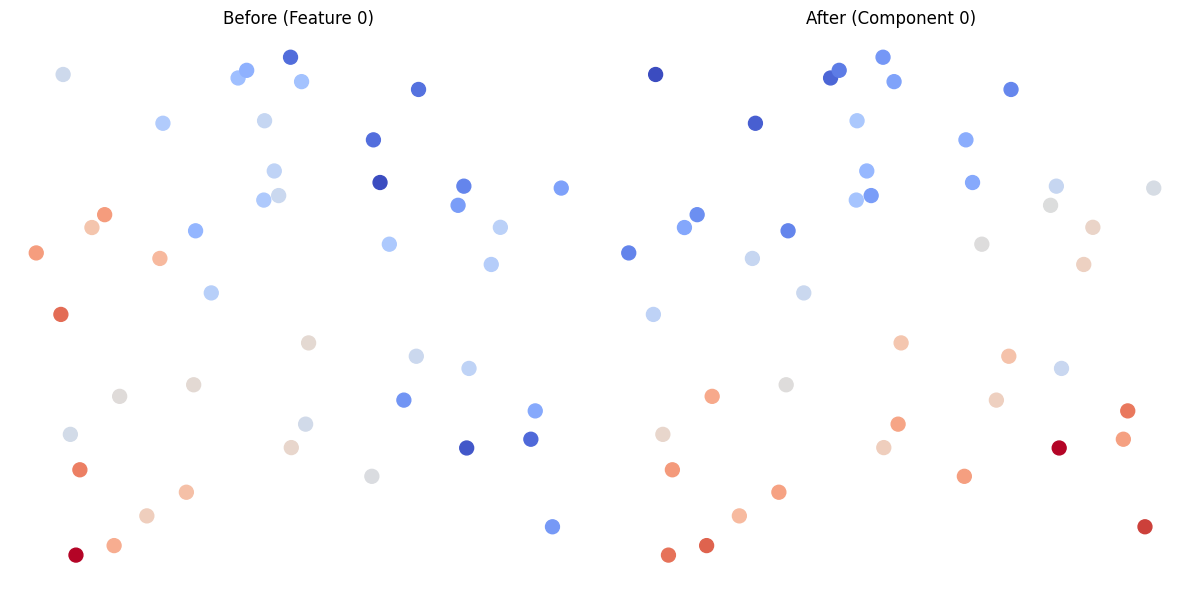

In [ ]:
def visualize_projection_change(graph, extractor, component_index=0, feature_index=0, title_prefix=""):
    """
    Visualizes a graph before and after applying the learned spatial projection.
    Also prints Moran's I for the input feature and projected component.

    Args:
        graph: A single graph (DummyGraph) with .x and .coords
        extractor: A trained SimultaneousSAILBasisExtractorStochastic instance
        component_index: Which learned projection direction to visualize
        feature_index: Which input feature to show for the 'before' case
        title_prefix: Optional prefix string for titles
    """
    import matplotlib.pyplot as plt
    import networkx as nx
    from copy import deepcopy

    device = extractor.W.device

    # Move tensors to same device
    graph.x = graph.x.to(device)
    graph.coords = graph.coords.to(device)
    if hasattr(graph, "edge_index") and graph.edge_index is not None:
        graph.edge_index = graph.edge_index.to(device)

    # Original and projected features
    x_before = graph.x[:, feature_index].detach().cpu()
    W = extractor.W[component_index]  # (in_dim,)
    z_after = graph.x @ W             # (n_nodes,)
    x_after = z_after.detach().cpu()

    # Prepare temporary graphs
    dummy_before = deepcopy(graph)
    dummy_before.x = x_before.unsqueeze(1).to(device)

    dummy_after = deepcopy(graph)
    dummy_after.x = z_after.unsqueeze(1).to(device)

    # Compute Moran's I before and after
    sail = extractor.sail_class(
        f_map=IdentityMap(),
        f_theta=extractor.f_theta,
        num_heads=1,
        use_median_distance=False,
        use_edge_connections=False,
        reinit_weights=True,
        learnable_temperature=False
    )

    moran_before, _ = sail(dummy_before)
    moran_after, _ = sail(dummy_after)

    print(f"🌐 Moran's I BEFORE (Feature {feature_index}):  {moran_before.item():.4f}")
    print(f"🌐 Moran's I AFTER  (Component {component_index}): {moran_after.item():.4f}")

    # Visualization
    coords = graph.coords.detach().cpu().numpy()
    G = nx.Graph()
    for i, (x, y) in enumerate(coords):
        G.add_node(i, pos=(x, y))
    if hasattr(graph, "edge_index") and graph.edge_index is not None:
        edge_index = graph.edge_index.detach().cpu().numpy()
        for i, j in zip(edge_index[0], edge_index[1]):
            G.add_edge(int(i), int(j))

    pos = nx.get_node_attributes(G, 'pos')
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    nx.draw(
        G, pos, node_color=x_before.numpy(), cmap="coolwarm",
        node_size=100, edge_color="gray", ax=axes[0]
    )
    axes[0].set_title(f"{title_prefix}Before (Feature {feature_index})")

    nx.draw(
        G, pos, node_color=x_after.numpy(), cmap="coolwarm",
        node_size=100, edge_color="gray", ax=axes[1]
    )
    axes[1].set_title(f"{title_prefix}After (Component {component_index})")

    plt.tight_layout()
    plt.show()

print(graphs.label)
visualize_projection_change(graphs, extractor, component_index=0, feature_index=0)


In [ ]:
rain_ds

NameError: name 'rain_ds' is not defined

In [ ]:
for i, component_projections in enumerate(projections):  # i = component index
    for j, z in enumerate(component_projections):        # j = graph index
        graph = graph_list[j]  # or dataset[j] if you're using a DataLoader
        graph_proj = DummyGraph(x=z.unsqueeze(1), coords=graph.coords, label=None)
        title = f"Component {i+1} on Graph {j+1}"
        visualize_graph(graph_proj, z, title=title, show="local")
        break
